In [52]:
import os
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse.linalg import svds
from sklearn.preprocessing import normalize


In [53]:
index_to_title = {}
i = 0
for filename in os.listdir("scripts"):
    index_to_title[i] = filename
    i += 1
script_array = [None] * len(index_to_title.keys())

In [54]:
i = 0
for script in index_to_title.values():
    try:
        # Read the script
        with open("scripts/" + script, 'r', encoding='utf-8') as file:
            script_text = file.read()
        
        # Preprocess the script
        script_text = script_text.lower()
        script_text = re.sub(f'[{string.punctuation}]', ' ', script_text)
        script_text = re.sub(r'\s+', ' ', script_text).strip()
        
        index_to_title[i] = script
        script_array[i] = script_text
        i += 1

    except Exception as e:
        print(f"Error processing script: {e}")

In [55]:
vectorizer = TfidfVectorizer(stop_words = 'english', max_df = .7, min_df = 75)

td_matrix = vectorizer.fit_transform(script_array)

In [56]:
print(type(td_matrix))
print(td_matrix.shape)

<class 'scipy.sparse._csr.csr_matrix'>
(1231, 9156)


In [57]:
u, s, v_trans = svds(td_matrix, k=100)

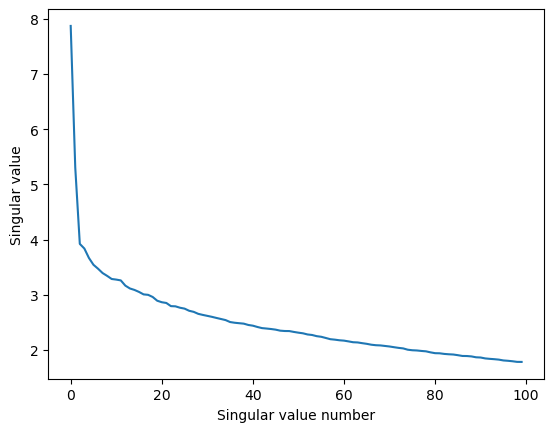

In [58]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(s[::-1])
plt.xlabel("Singular value number")
plt.ylabel("Singular value")
plt.show()

In [59]:
docs_compressed, s, words_compressed = svds(td_matrix, k=20)
words_compressed = words_compressed.transpose()

In [60]:
print(words_compressed.shape)
print(docs_compressed.shape)

(9156, 20)
(1231, 20)


In [61]:
word_to_index = vectorizer.vocabulary_
index_to_word = {i:t for t,i in word_to_index.items()}

#row normalize
words_compressed_normed = normalize(words_compressed, axis = 1)

# cosine similarity
def closest_words(word_in, words_representation_in, k = 10):
    if word_in not in word_to_index: return "Not in vocab."
    sims = words_representation_in.dot(words_representation_in[word_to_index[word_in],:])
    asort = np.argsort(-sims)[:k+1]
    return [(index_to_word[i],sims[i]) for i in asort[1:]]

td_matrix_np = td_matrix.transpose().toarray()
td_matrix_np = normalize(td_matrix_np)

In [62]:
word = 'punch'
print("Using SVD:")
for w, sim in closest_words(word, words_compressed_normed):
  try:
    print("{}, {:.3f}".format(w, sim))
  except:
    print("word not found")
print()
print("Without using SVD: using term-doc matrix directly:")
for w, sim in closest_words(word, td_matrix_np):
  try:
    print("{}, {:.3f}".format(w, sim))
  except:
    print("word not found")
print()

Using SVD:
split, 0.976
smash, 0.957
stick, 0.948
gut, 0.947
whipped, 0.945
sticks, 0.944
kick, 0.943
wrestles, 0.941
copy, 0.940
team, 0.938

Without using SVD: using term-doc matrix directly:
punches, 0.523
lands, 0.454
jaw, 0.451
fists, 0.442
belt, 0.436
boxing, 0.412
gym, 0.391
fights, 0.388
kick, 0.388
hitting, 0.386



## Finding similar projects (movies)

In [112]:
docs_compressed_normed = normalize(docs_compressed)

# this is basically the same cosine similarity code that we used before, just with some changes to
# the returned output format to let us print out the documents in a sensible way
def closest_projects(project_index_in, project_repr_in, k = 5):
    sims = project_repr_in.dot(project_repr_in[project_index_in,:])
    asort = np.argsort(-sims)[:k+1]
    
    return [(index_to_title[i],sims[i]) for i in asort[1:]]


In [ ]:
for i in range(10):
    print("INPUT PROJECT: "+ index_to_title[i])
    print("CLOSEST PROJECTS:")
    print("Using SVD:")
    for title, score in closest_projects(i, docs_compressed_normed):
        print("{}:{:.3f}".format(title, score))
    print()

## Finding movies based on a word

In [123]:
# Once again, basically the same cosine similarity code, but mixing two different matrices
def closest_projects_to_word(word_in, k = 10):
    if word_in not in word_to_index: return "Not in vocab."
    sims = docs_compressed_normed.dot(words_compressed_normed[word_to_index[word_in],:])
    asort = np.argsort(-sims)[:k+1]
    return [(i, index_to_title[i],sims[i]) for i in asort[1:]]

In [128]:
for i, proj, sim in closest_projects_to_word("burger"):
    print("({}, {}, {:.4f}".format(i, proj, sim))

(240, Butterfly-Effect,-The.txt, 0.8532
(211, Bound.txt, 0.8114
(632, Joker.txt, 0.8045
(137, Bad-Santa.txt, 0.7835
(1143, True-Romance.txt, 0.7832
(275, Clerks.txt, 0.7756
(924, Replacements,-The.txt, 0.7756
(902, Pulp-Fiction.txt, 0.7714
(297, Cradle-2-the-Grave.txt, 0.7639
(913, Rambling-Rose.txt, 0.7638
